In [1]:
from dotenv import load_dotenv
import os
GIT_TOKEN = os.getenv("GIT_TOKEN")
load_dotenv()



True

#### State 설정

In [2]:
from typing import Literal
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI

class AgentState(TypedDict):
    """The state of our agent."""
    question: str
    certainty_score: int
    search_results: list
    web_score: str
    repo_name: str
    generation: str

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)



#### 질문에 대한 LLM의 답변 신뢰도 점검

In [3]:
from pydantic import BaseModel, Field

def check_certainty(state: AgentState) -> AgentState:
    """Evaluate certainty score for the query."""
    question = state["question"]

    class CertaintyScoreResponse(BaseModel):
        score: int = Field(description="Certainty score from 1 to 100. Higher is better.")

    certainty_score = llm.with_structured_output(CertaintyScoreResponse)

    print("--- Checking LLM's Certainty ---")
    score_response = certainty_score.invoke(question)

    return {
        "certainty_score": score_response.score
    }

In [4]:
def route_based_on_certainty(state: AgentState) -> Literal["web_search", "direct_response"]:
    """Route to appropriate node based on certainty score."""
    score = state["certainty_score"]

    if score != 100:
        print("--- LLM is not certain so It will do web Search ---")
        return "web_search"
    else:
        print("--- LLM is certain so It will generate answer directly ---")
        return "direct_response"

In [5]:
question = "Langgraph로 rag를 구축하는 방법"

score_print = check_certainty({"question": question})
print(score_print)


--- Checking LLM's Certainty ---
{'certainty_score': 85}


#### LLM이 스스로 답변할 수 있는 경우의 노드

In [6]:
def direct_response(state: AgentState):
    question = state["question"]
    result = llm.invoke(question)
    return {"generation": result.content}

#### 웹 검색 기반의 답변 가능 여부 판단

In [7]:
from typing import Literal
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

def web_search(state: AgentState) -> AgentState:
    """
    Perform web search and evaluate results.
    """
    question = state["question"]

    search_tool = TavilySearchResults(max_results=3)
    search_results = search_tool.invoke(question)

    class answer_available(BaseModel):
        """Binary score for answer availability."""
        binary_score: str = Field(description="""
                                    If web search result can solve the user's ask, answer 'yes'.
                                    If not, answer 'no'""")
    
    evaluator = llm.with_structured_output(answer_available)
    eval_prompt = ChatPromptTemplate.from_messages([
        ("system", "Evaluate if these search results can answer the user's question with a simple yes/no."),
        ("user", """
         Question: {question}
         Seach Result: {results}
         Can these results answer the question adequately?
         """)
    ])

    print("--- Check whether web search is sufficient for user's ask ---")

    evaluation = evaluator.invoke(
        eval_prompt.format(
            question=question, results="\n".join(f"- {result['content']}" for result in search_results)
        )
    )

    return {
        "search_results": search_results,
        "web_score": evaluation.binary_score
    }
    


#### 웹 검색으로 해결 가능한지 여부 판단

In [8]:
from langchain_community.tools import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate

question = "autorag github에서 명시된 설치 방법을 알려줘"

result = web_search({"question": question})
print(result)


--- Check whether web search is sufficient for user's ask ---
{'search_results': [{'url': 'https://github.com/Marker-Inc-Korea/AutoRAG/blob/main/docs/source/install.md', 'content': 'To install AutoRAG, you can use pip:\n\nPlus, it is recommended to install PyOpenSSL and nltk libraries for full features.\n\nNote for Windows Users\n\nAutoRAG is not fully supported on Windows yet. There are several constraints for Windows users.\n\nDue to the constraints, we recommend using Docker images for running AutoRAG on Windows.\n\nPlus, you MAKE SURE UPGRADE UP TO v0.3.1 for Windows users.\n\nInstallation for Local Models 🏠 [...] For using local models, you need to install some additional dependencies.\n\nInstallation for Parsing 🌲\n\nFor parsing you need to install some local packages like libmagic,\ntesseract, and poppler.\nThe installation method depends upon your OS.\n\nAfter installing this, you can install AutoRAG with parsing like below.\n\nInstallation for Korean 🇰🇷\n\nYou can install opti

#### 웹 검색 결과로 해결 가능/불가능 여부로 다음 노드 라우팅하는 함수 정의

In [9]:
def route_after_search(state: AgentState) -> Literal["generate", "github_search"]:
    """
    Route based on search evaluation.
    """
    if state["web_score"] == "yes":
        print("--- 웹검색 결과로 해결 가능 ---")
        return "web_generate"
    else:
        print("--- 웹검색 결과로 해결 불가, 깃허브 검색 진행 ---")
        return "github_search"

#### 웹검색 기반 답변 노드

In [16]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

def web_generate(state: AgentState):
    question = state["question"]
    web_results = state["search_results"]

    def format_web_results(results):
        formatted = []
        for i, result in enumerate(results, 1):
            formatted.append(f"Source {i}: \nURL: {result['url']}\nContent: {result['content']}\n")
        return "\n".join(formatted)
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a helpful assistant that generates comprehensive answers based on web search results.
        Use the provided search results to answer the user's question.
        Make sure to synthesize information from multiple sources when possible.
        If the search results don't contain enough information to fully answer the question, acknowledge this limitation."""),
        ("user", """Question: {question}

        Search Results:
        {web_results}

        Please provide a detailed answer based on these search results. Answer in Korean""")
    ])
    chain = (
        {
            "question": lambda x: x["question"],
            "web_results": lambda x: format_web_results(x["web_results"])
        }
        | prompt
        | llm
        | StrOutputParser()
    )

    print("--- 웹 검색 결과 기반 답변 생성중 ---")
    response = chain.invoke({
        "question": question,
        "web_results": web_results
    })

    return {"generation": response}


#### 깃헙 레포 정보를 가져오는 함수

In [11]:
from langchain_community.document_loaders import GithubFileLoader
from chromadb.config import Settings
import chromadb
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

def git_loader(repo, branch_name):
    loader = GithubFileLoader(
        repo=repo,
        branch=branch_name,
        access_token=GIT_TOKEN,
        github_api_url="https://api.github.com",
        file_filter=lambda file_path: file_path.endswith(".md"),    # 내가 가져올 파일 확장자자
    )

    documents = loader.load()

    return documents

def git_vector_embedding(repo_name):
    client = chromadb.Client(Settings(
        is_persistent=True,
        persis_directory="./chroma_db"  # 저장될 디렉토리 지정
    ))

    collection_name = repo_name.split("/")[1]

    existing_collections = client.list_collections()
    if collection_name in [col.name for col in existing_collections]:
        print(f"--- Loading existing collection for {collection_name} ---")
        vectorstore = Chroma(
            client=client,
            collection_name=collection_name,
            embedding_function=OpenAIEmbeddings(),
        )
    else:
        print(f"--- Creating new collection for {collection_name} ---")
        try:
            git_docs = git_loader(repo_name, "master")
        except:
            git_docs = git_loader(repo_name, "main")

        text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
            chunk_size=500, chunk_overlap=50
        )
        docs_splits = text_splitter.split_documents(git_docs)

        vectorstore = Chroma.from_documents(
            documents=docs_splits,
            collection_name=collection_name,
            embedding=OpenAIEmbeddings(),
            client=client
        )

    return vectorstore


#### 깃헙 레포 정보 기반의 답변 생성 노드

In [12]:
from langchain import hub

def github_generate(state: AgentState) -> AgentState:
    """
    Find relevant Github repositories for the user's question.
    """
    class GitHubRepo(BaseModel):
        """Best matching Github repository."""
        repo_name: str = Field(description="Full repository name in format 'owner/repo'")

    question = state["question"]

    search_tool = TavilySearchResults(max_results=5)
    search_results = search_tool.invoke(
        f"github repository {question} site:github.com" # 깃허브에서만 검색하도록 필터링
    )

    eval_prompt = ChatPromptTemplate.from_messages([
        {"system", """You are an expert at identifying the most relevant Github repository.
         Analyze the search results and identify the Single most relevant Github repository.
         Return ONLY the rpository name in the format 'owner/repo'."""},
         ("user", """
          Question: {question}
          Search Results: {results}
          
          What is the most relevant repository name?""")
    ])

    repo_extractor = llm.with_structured_output(GitHubRepo)

    best_repo = repo_extractor.invoke(
        eval_prompt.format(
            question=question,
            results="\n\n".join(f"URL: {result['url']}\nContent: {result['content']}" for result in search_results)
        )
    )
    repo_name = best_repo.repo_name
    vectorstore = git_vector_embedding(repo_name)
    retriever = vectorstore.as_retriever()
    prompt = hub.pull("rlm/rag-prompt") # "rlm/rag-prompt" 라는 프롬프트안에 "context"와 "question"이 있음

    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)
    
    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
    )

    print("--- 깃허브 레포 정보 기반 답변 생성중 ---")
    result = rag_chain.invoke(question)
    return {"generation": result}
    


#### 그래프 구축

In [17]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(AgentState)

workflow.add_node("check_certainty", check_certainty)
workflow.add_node("direct_response", direct_response)
workflow.add_node("web_search", web_search)
workflow.add_node("web_generate", web_generate)
workflow.add_node("github_generate", github_generate)

workflow.add_edge(START, "check_certainty")

workflow.add_conditional_edges(
    "check_certainty",
    route_based_on_certainty,
    {
        "web_search": "web_search",
        "direct_response": "direct_response"
    }
)

workflow.add_conditional_edges(
    "web_search",
    route_after_search,
    {
        "web_generate": "web_generate",
        "github_generate": "github_generate"
    }
)

workflow.add_edge("direct_response", END)
workflow.add_edge("web_generate", END)
workflow.add_edge("github_generate", END)

app = workflow.compile()

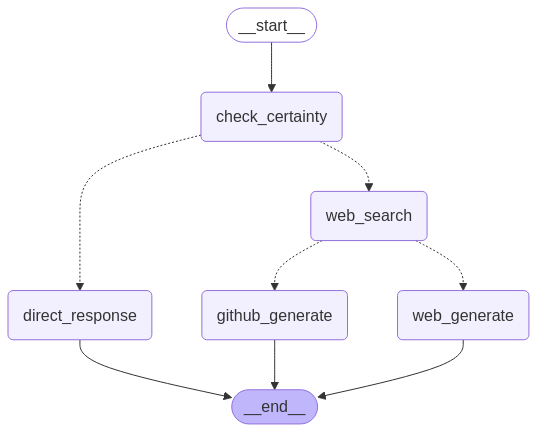

In [14]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))


In [18]:
import pprint

inputs = {
    "question": "Yolo v5를 실행하는 방법에 대해 알아? 코드를 알려줄래?"
}

for output in app.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"### Output from node : '{key}':")
        pprint.pprint("----------")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n--------\n")


--- Checking LLM's Certainty ---
--- LLM is not certain so It will do web Search ---
"### Output from node : 'check_certainty':"
'----------'
{'certainty_score': 90}
'\n--------\n'
--- Check whether web search is sufficient for user's ask ---
--- 웹검색 결과로 해결 가능 ---
"### Output from node : 'web_search':"
'----------'
{ 'search_results': [ { 'content': '오늘은 YOLO v5 모델에 대해서 공부해보겠습니다 두둥욜로~욜로는 딥러닝 '
                                   '기반으로 객체를 인식해주는 모델이랍니다Colab 환경에서 실행해주겠습니다.',
                        'url': 'https://velog.io/@yooniverseis/YOLO-v5-%EC%8B%A4%EC%8A%B5%ED%95%B4%EB%B3%B4%EA%B8%B0'},
                      { 'content': '먼저 https://github.com/ultralytics/yolov5 '
                                   '사이트에 방문하여 다운로드를 진행하자. 파이썬에서 가상환경을 만들고 난 뒤 '
                                   'git clone을 통해 소스코드',
                        'url': 'https://ipsmaster.tistory.com/134'},
                      { 'content': '추가로 conda에 설치하면 더 좋다. 즉 콘다 설치 후. # 콘다 환경 '
                                   '만든 